In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_ipc=pd.read_csv("Data/FewsNetPopulation/ethiopia_admin1_fewsnet_population_20090701_20200801.csv",index_col=0)
df_ipc['date'] = pd.to_datetime(df_ipc['date'])
df_ipc['year'] = df_ipc['date'].dt.year
df_ipc['month'] = df_ipc['date'].dt.month
adm1c='ADM1_EN' #"ADMIN1" #

In [3]:
#calculate percentage of population per status and level
for status in ["CS","ML1","ML2"]:
    for i in range(1,6):
        c=f"{status}_{i}"
        df_ipc[f"perc_{c}"]=df_ipc[c]/df_ipc[f"pop_{status}"]*100
    df_ipc[f"perc_{status}_3p"]=(df_ipc[[f"{status}_{i}" for i in range(3,6)]].sum(axis=1)/df_ipc[f"pop_{status}"]*100).round(2)

In [4]:
#not ever been or forecasted to be IPC 5
df_ipc.ML2_5.unique()

array([0.])

In [5]:
df_ipc.head()

,date,ADM1_EN,Total,adjusted_population,CS_1,CS_2,CS_3,CS_4,CS_5,ML1_1,...,perc_ML1_3,perc_ML1_4,perc_ML1_5,perc_ML1_3p,perc_ML2_1,perc_ML2_2,perc_ML2_3,perc_ML2_4,perc_ML2_5,perc_ML2_3p
0,2009-07-01,Addis Ababa,3585647,3077903,3077903.0,0.0,0.0,0.0,0.0,3077903.0,...,0.000000,0.0,0.0,0.00,100.000000,0.000000,0.000000,0.0,0.0,0.00
1,2009-07-01,Afar,1904414,1634738,0.0,793494.0,841244.0,0.0,0.0,0.0,...,51.460479,0.0,0.0,51.46,0.000000,59.535106,40.464894,0.0,0.0,40.46
2,2009-07-01,Amhara,21790172,18704582,10758849.0,1968379.0,5977354.0,0.0,0.0,10758849.0,...,31.956630,0.0,0.0,31.96,45.923058,54.076942,0.000000,0.0,0.0,0.00
3,2009-07-01,Benishangul Gumz,1102849,946679,946679.0,0.0,0.0,0.0,0.0,946679.0,...,0.000000,0.0,0.0,0.00,100.000000,0.000000,0.000000,0.0,0.0,0.00
4,2009-07-01,Dire Dawa,508918,436852,0.0,436852.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.00,0.000000,100.000000,0.000000,0.0,0.0,0.00


In [6]:
def get_trigger(row, status, level, perc):
    # range till 6 cause 5 is max level
    cols = [f"{status}_{l}" for l in range(level, 6)]
    if np.isnan(row[f"pop_{status}"]):
        return np.nan
    if row[cols].sum() >= row[f"pop_{status}"] / (100 / perc):
        return 1
    else:
        return 0


def get_trigger_increase_rel(row, level, perc):
    # range till 6 cause 5 is max level
    cols_ml1 = [f"ML1_{l}" for l in range(level, 6)]
    cols_cs = [f"CS_{l}" for l in range(level, 6)]
    if row[["pop_CS", "pop_ML1"]].isnull().values.any():
        return np.nan
    if row[cols_ml1].sum() == 0:
        return 0
    if row[cols_ml1].sum() >= row[cols_cs].sum() * (1 + (perc / 100)):
        return 1
    else:
        return 0
    
def get_trigger_increase(row, level, perc):
    # range till 6 cause 5 is max level
    cols_ml1 = [f"ML1_{l}" for l in range(level, 6)]
    cols_cs = [f"CS_{l}" for l in range(level, 6)]
    if row[["pop_CS", "pop_ML1"]].isnull().values.any():
        return np.nan
    if row[cols_ml1].sum() == 0:
        return 0
    if (row[cols_ml1].sum() - row[cols_cs].sum())/row["pop_CS"]*100>= perc:
        return 1
    else:
        return 0

In [7]:
# At least 20% of ADMIN1 population
# currently at IPC3+ 
# AND
# 5% increase in ADMIN1 pop. 
# projected in IPC3+ in 3 months
# "trigger_ML1_3_5i" "trigger_CS_3_20"

In [8]:
#get yes/no for different thresholds
df_ipc["trigger_CS_3_20"]=df_ipc.apply(lambda x: get_trigger(x,"CS",3,20),axis=1)
df_ipc["trigger_CS_3_40"]=df_ipc.apply(lambda x: get_trigger(x,"CS",3,40),axis=1)
df_ipc["trigger_CS_4_2"]=df_ipc.apply(lambda x: get_trigger(x,"CS",4,2.5),axis=1)
df_ipc["trigger_CS_4_20"]=df_ipc.apply(lambda x: get_trigger(x,"CS",4,20),axis=1)
df_ipc["trigger_CS_4_10"]=df_ipc.apply(lambda x: get_trigger(x,"CS",4,10),axis=1)
df_ipc["trigger_CS_4_1"]=df_ipc.apply(lambda x: get_trigger(x,"CS",4,0.1),axis=1)
df_ipc["trigger_ML1_3_5"]=df_ipc.apply(lambda x: get_trigger(x,"ML1",3,5),axis=1)
df_ipc["trigger_ML1_4_2"]=df_ipc.apply(lambda x: get_trigger(x,"ML1",4,2.5),axis=1)
df_ipc["trigger_ML1_4_20"]=df_ipc.apply(lambda x: get_trigger(x,"ML1",4,20),axis=1)
df_ipc["trigger_ML1_3_20"]=df_ipc.apply(lambda x: get_trigger(x,"ML1",3,20),axis=1)
df_ipc["trigger_ML1_3_30"]=df_ipc.apply(lambda x: get_trigger(x,"ML1",3,30),axis=1)
df_ipc["trigger_ML1_3_5ir"]=df_ipc.apply(lambda x: get_trigger_increase_rel(x,3,5),axis=1)
df_ipc["trigger_ML1_3_40ir"]=df_ipc.apply(lambda x: get_trigger_increase_rel(x,3,40),axis=1)
df_ipc["trigger_ML1_3_70ir"]=df_ipc.apply(lambda x: get_trigger_increase_rel(x,3,70),axis=1)
df_ipc["trigger_ML1_3_5i"]=df_ipc.apply(lambda x: get_trigger_increase(x,3,5),axis=1)
df_ipc["trigger_ML1_3_10i"]=df_ipc.apply(lambda x: get_trigger_increase(x,3,10),axis=1)
df_ipc["trigger_ML1_3_20i"]=df_ipc.apply(lambda x: get_trigger_increase(x,3,20),axis=1)
df_ipc["trigger_ML1_3_30i"]=df_ipc.apply(lambda x: get_trigger_increase(x,3,30),axis=1)
df_ipc["trigger_ML1_3_40i"]=df_ipc.apply(lambda x: get_trigger_increase(x,3,40),axis=1)
df_ipc["trigger_ML1_3_50i"]=df_ipc.apply(lambda x: get_trigger_increase(x,3,50),axis=1)
df_ipc["trigger_ML1_3_70i"]=df_ipc.apply(lambda x: get_trigger_increase(x,3,70),axis=1)

In [9]:
dict_an={}

In [10]:
#Analysis 1: 20% IPC3+ (current situation) + 2.5% IPC4+ (current situation)
df_an1 = df_ipc.loc[(df_ipc['trigger_CS_3_20']==1)&(df_ipc['trigger_ML1_4_2']==1)]
dict_an["an1"]={"df":df_an1,"trig_cols":["CS_3","CS_4","ML1_4"],"desc":"20% IPC3+ (current situation) + 2.5% IPC4+ (current situation)"}
dict_an["an1"]["df_group"]=df_an1.groupby(['date','year'], as_index=False)[adm1c].agg(lambda x: list(x))
display(df_an1.groupby(['year', 'month'], as_index=False)[adm1c].agg(lambda x: list(x)))

,year,month,ADM1_EN
0,2009,7,[Somali]
1,2010,1,"[Afar, Gambela, Somali]"
2,2011,4,[Somali]
3,2011,7,"[Oromia, Somali]"
4,2015,10,[Afar]
5,2016,2,"[Afar, Oromia]"
6,2017,6,[Somali]
7,2017,10,[Somali]


In [11]:
#Analysis 1b: 20% IPC3+ (current situation) + (2.5% IPC4+ (current situation) OR 5% increase in IPC3+ (ML1))
df_an1b = df_ipc.loc[(df_ipc['trigger_CS_3_20']==1)&((df_ipc['trigger_ML1_4_2']==1)| (df_ipc['trigger_ML1_3_5i'] == 1))]
dict_an["an1b"]={"df":df_an1b,"trig_cols":["CS_3","CS_4","ML1_4"],"desc":"20% IPC3+ (current situation) + (2.5% IPC4+ (current situation) OR 5% increase in IPC3+ (ML1))"}
dict_an["an1b"]["df_group"]=df_an1b.groupby(['date','year'], as_index=False)[adm1c].agg(lambda x: list(x))
display(df_an1b.groupby(['year', 'month'], as_index=False)[adm1c].agg(lambda x: list(x)))

,year,month,ADM1_EN
0,2009,7,[Somali]
1,2010,1,"[Afar, Gambela, Somali]"
2,2011,4,[Somali]
3,2011,7,"[Oromia, Somali]"
4,2012,4,[Afar]
5,2013,1,[Somali]
6,2015,10,[Afar]
7,2016,2,"[Afar, Amhara, Oromia]"
8,2017,6,[Somali]
9,2017,10,[Somali]


In [12]:
# #Analysis 1c: 20% IPC3+ (current situation) + 5% increase in IPC3+ (ML1)
# df_snCS20ML1i = df_ipc.loc[(df_ipc['trigger_CS_3_20']==1)&(df_ipc['trigger_ML1_3_5i'] == 1)]
# df_snCS20ML1i.groupby(['year', 'month'], as_index=False)['ADM1_EN'].agg(lambda x: list(x))

In [13]:
#Analysis 2: 20% IPC3+ (current situation) + 2.5% IPC4+ (current situation) + 5% increase in IPC3+ (ML1)
df_an2 = df_ipc.loc[(df_ipc['trigger_CS_3_20']==1)&(df_ipc['trigger_CS_4_2']==1) & (df_ipc['trigger_ML1_3_5ir'] == 1)]
dict_an["an2"]={"df":df_an2,"trig_cols":["CS_3","CS_4","ML1_4"],"desc":"20% IPC3+ (current situation) + 2.5% IPC4+ (current situation) + 5% increase in IPC3+ (ML1)"}
df_an2.groupby(['year', 'month'], as_index=False)['ADM1_EN'].agg(lambda x: list(x))

,year,month,ADM1_EN
0,2016,2,[Oromia]
1,2017,10,[Somali]


In [14]:
#Analysis 3: IPC4 at 20% (current situation)
df_an3 = df_ipc.loc[df_ipc['trigger_CS_4_20']==1]
display(df_an3.groupby(['year', 'month'], as_index=False)['ADM1_EN'].agg(lambda x: list(x)))
dict_an["an3"]={"df":df_an3,"trig_cols":["CS_4"],"desc":"IPC4 at 20% (current situation)"}

,year,month,ADM1_EN
0,2009,7,[Somali]
1,2009,10,[Somali]
2,2011,4,[Somali]
3,2011,7,[Somali]
4,2011,10,[Somali]
5,2017,6,[Somali]
6,2017,10,[Somali]


In [15]:
#Analysis 3b: IPC4+ at > 0.1% (current situation)
df_snCS41 = df_ipc.loc[df_ipc['trigger_CS_4_1']==1]
display(df_snCS41.groupby(['year', 'month'], as_index=False)['ADM1_EN'].agg(lambda x: list(x)))
dict_an["an3b"]={"df":df_snCS41,"trig_cols":["CS_4"],"desc":"IPC4+ at >0.1% (current situation)"}

,year,month,ADM1_EN
0,2009,7,[Somali]
1,2009,10,[Somali]
2,2010,4,[Amhara]
3,2011,4,[Somali]
4,2011,7,"[Oromia, Somali]"
5,2011,10,"[Oromia, Somali]"
6,2012,1,[Oromia]
7,2015,10,"[Afar, Somali]"
8,2016,2,"[Afar, Oromia, Somali]"
9,2017,6,[Somali]


In [16]:
#Analysis 5: IPC4+ at 10% (current situation)
df_an5 = df_ipc.loc[df_ipc['trigger_CS_4_10']==1]
display(df_an5.groupby(['year', 'month'], as_index=False)['ADM1_EN'].agg(lambda x: list(x)))
dict_an["an5"]={"df":df_an5,"trig_cols":["CS_4"],"desc":"IPC4+ at 10% (current situation)"}

,year,month,ADM1_EN
0,2009,7,[Somali]
1,2009,10,[Somali]
2,2011,4,[Somali]
3,2011,7,[Somali]
4,2011,10,[Somali]
5,2015,10,"[Afar, Somali]"
6,2016,2,"[Afar, Oromia, Somali]"
7,2017,6,[Somali]
8,2017,10,[Somali]


In [17]:
"40% IPC3+ (current situation) + 40% increase in number of people in IPC3+ (ML1)"
df_an7 = df_ipc.loc[(df_ipc['trigger_CS_3_40']==1)&(df_ipc['trigger_ML1_3_40ir']==1)]
# df_an1 = df_ipc.loc[(df_ipc['trigger_CS_3_20']==1)&(df_ipc['trigger_ML1_4_2']==1)]
# display(df_an7[["date","ADM1_EN","perc_ML1_3","perc_ML1_4","perc_CS_3","perc_CS_4","CS_3","CS_4","ML1_3","ML1_4"]])
display(df_an7.groupby(['year', 'month'], as_index=False)['ADM1_EN'].agg(lambda x: list(x)))
dict_an["an7"]={"df":df_an7,"trig_cols":["ML1_3","CS_3","CS_4","ML1_4"],"desc":"40% IPC3+ (current situation) + 40% increase in number of people in IPC3+ (ML1)"}

,year,month,ADM1_EN
0,2010,1,[Somali]
1,2020,6,"[Afar, Somali]"
2,2020,8,"[Afar, Somali]"


In [18]:
#Analysis 8: 5% increase in IPC3+ (ML1)
df_an8 = df_ipc.loc[(df_ipc['trigger_ML1_3_5i']==1)]
# df_an1 = df_ipc.loc[(df_ipc['trigger_CS_3_20']==1)&(df_ipc['trigger_ML1_4_2']==1)]
# display(df_an7[["date","ADM1_EN","perc_ML1_3","perc_ML1_4","perc_CS_3","perc_CS_4","CS_3","CS_4","ML1_3","ML1_4"]])
display(df_an8.groupby(['year', 'month'], as_index=False)['ADM1_EN'].agg(lambda x: list(x)))
dict_an["an8"]={"df":df_an8,"trig_cols":["ML1_3","CS_3","CS_4","ML1_4"],"desc":"5% increase in number of people in IPC3+ (ML1)"}

,year,month,ADM1_EN
0,2009,7,[Gambela]
1,2010,1,"[Afar, Amhara, Dire Dawa, Harari, Oromia, Soma..."
2,2010,10,[Somali]
3,2012,4,[Afar]
4,2013,1,"[Amhara, SNNP, Somali]"
5,2016,2,"[Amhara, Oromia]"
6,2017,6,"[Oromia, Tigray]"
7,2017,10,[Somali]
8,2018,6,[Amhara]
9,2019,2,"[Oromia, SNNP, Somali]"


In [19]:
#Analysis 9: 10% increase in IPC3+ (ML1)
df_an9 = df_ipc.loc[(df_ipc['trigger_ML1_3_30i']==1)]
# df_an1 = df_ipc.loc[(df_ipc['trigger_CS_3_20']==1)&(df_ipc['trigger_ML1_4_2']==1)]
# display(df_an9[["date","ADM1_EN","perc_ML1_3","perc_ML1_4","perc_CS_3","perc_CS_4","CS_3","CS_4","ML1_3","ML1_4","ML1_i","ML1_i2"]])
display(df_an9.groupby(['year', 'month'], as_index=False)['ADM1_EN'].agg(lambda x: list(x)))
dict_an["an9"]={"df":df_an9,"trig_cols":["ML1_3","CS_3","CS_4","ML1_4"],"desc":"30% increase in number of people in IPC3+ (ML1) relative to total population Admin"}

,year,month,ADM1_EN
0,2009,7,[Gambela]
1,2010,1,"[Dire Dawa, Harari, Somali, Tigray]"
2,2012,4,[Afar]
3,2013,1,"[SNNP, Somali]"
4,2020,6,"[Afar, Harari]"
5,2020,8,"[Afar, Harari]"


In [20]:
# #Analysis 10: At least 20% of ADMIN1 population currently at IPC3+  AND5% increase in ADMIN1 pop. projected in IPC3+ in 3 months
# df_an10b = df_ipc.loc[(df_ipc["trigger_CS_3_20"]==1) & (df_ipc["trigger_ML1_3_5i"]==1)]
# # df_an1 = df_ipc.loc[(df_ipc['trigger_CS_3_20']==1)&(df_ipc['trigger_ML1_4_2']==1)]
# # display(df_an9[["date","ADM1_EN","perc_ML1_3","perc_ML1_4","perc_CS_3","perc_CS_4","CS_3","CS_4","ML1_3","ML1_4","ML1_i","ML1_i2"]])
# display(df_an10b.groupby(['year', 'month'], as_index=False)['ADM1_EN','perc_CS_3p','perc_ML1_3p'].agg(lambda x: list(x)))
# dict_an["an10b"]={"df":df_an10b,"trig_cols":["ML1_3","CS_3","CS_4","ML1_4"],"desc":"At least 20% of ADMIN1 population currently at IPC3+  AND5% increase in ADMIN1 pop. projected in IPC3+ in 3 months"}

,year,month,ADM1_EN,perc_CS_3p,perc_ML1_3p
0,2010,1,"[Afar, Somali]","[74.23, 69.65]","[100.0, 100.0]"
1,2012,4,[Afar],[25.93],[59.69]
2,2013,1,[Somali],[28.13],[59.35]
3,2016,2,"[Amhara, Oromia]","[31.96, 30.16]","[38.4, 39.79]"
4,2017,10,[Somali],[49.84],[69.65]
5,2019,2,[Somali],[60.56],[81.82]
6,2020,6,"[Afar, Somali]","[40.46, 48.8]","[74.23, 75.68]"
7,2020,8,"[Afar, Somali]","[40.46, 48.8]","[89.0, 75.68]"


In [22]:
#Analysis 10: At least 20% of ADMIN1 population projected to be at IPC3+  AND5% increase in ADMIN1 pop. projected in IPC3+ in 3 months
df_an10 = df_ipc.loc[(df_ipc["trigger_ML1_3_20"]==1) & (df_ipc["trigger_ML1_3_5i"]==1)]
# df_an1 = df_ipc.loc[(df_ipc['trigger_CS_3_20']==1)&(df_ipc['trigger_ML1_4_2']==1)]
# display(df_an9[["date","ADM1_EN","perc_ML1_3","perc_ML1_4","perc_CS_3","perc_CS_4","CS_3","CS_4","ML1_3","ML1_4","ML1_i","ML1_i2"]])
display(df_an10.groupby(['year', 'month'], as_index=False)['ADM1_EN','perc_CS_3p','perc_ML1_3p','perc_ML2_3p'].agg(lambda x: list(x)))
dict_an["an10"]={"df":df_an10,"trig_cols":["ML1_3","CS_3","CS_4","ML1_4"],"desc":"At least 20% of ADMIN1 population in ML1 at IPC3+  AND5% increase in ADMIN1 pop. projected in IPC3+ in 3 months"}

,year,month,ADM1_EN,perc_CS_3p,perc_ML1_3p,perc_ML2_3p
0,2009,7,[Gambela],[0.0],[82.37],[0.0]
1,2010,1,"[Afar, Dire Dawa, Harari, Oromia, Somali, Tigray]","[74.23, 0.0, 0.0, 10.35, 69.65, 14.04]","[100.0, 100.0, 100.0, 34.35, 100.0, 49.26]","[100.0, 100.0, 100.0, 34.35, 100.0, 75.1]"
2,2010,10,[Somali],[4.33],[33.32],[33.32]
3,2012,4,[Afar],[25.93],[59.69],[0.0]
4,2013,1,"[Amhara, SNNP, Somali]","[2.37, 0.0, 28.13]","[25.26, 51.76, 59.35]","[27.87, 51.76, 17.72]"
5,2016,2,"[Amhara, Oromia]","[31.96, 30.16]","[38.4, 39.79]","[54.08, 44.09]"
6,2017,10,[Somali],[49.84],[69.65],[69.65]
7,2019,2,"[Oromia, Somali]","[9.88, 60.56]","[20.23, 81.82]","[20.59, 44.51]"
8,2020,2,[Afar],[14.54],[40.46],[74.23]
9,2020,6,"[Afar, Harari, Oromia, Somali]","[40.46, 0.0, 8.91, 48.8]","[74.23, 100.0, 23.04, 75.68]","[74.23, 0.0, 21.34, 69.65]"


In [23]:
#Analysis 11: At least 20% of ADMIN1 population at IPC4+ in ML1
df_an11 = df_ipc.loc[(df_ipc["trigger_ML1_4_20"]==1)]
# df_an1 = df_ipc.loc[(df_ipc['trigger_CS_3_20']==1)&(df_ipc['trigger_ML1_4_2']==1)]
# display(df_an9[["date","ADM1_EN","perc_ML1_3","perc_ML1_4","perc_CS_3","perc_CS_4","CS_3","CS_4","ML1_3","ML1_4","ML1_i","ML1_i2"]])
display(df_an11.groupby(['year', 'month'], as_index=False)['ADM1_EN','perc_ML1_4'].agg(lambda x: list(x)))
dict_an["an11"]={"df":df_an11,"trig_cols":["ML1_3","CS_3","CS_4","ML1_4"],"desc":"At least 20% of ADMIN1 population in IPC4+ at ML1"}

,year,month,ADM1_EN,perc_ML1_4
0,2009,7,[Somali],[62.29252071021442]
1,2010,1,"[Afar, Gambela, Somali]","[33.76556621396836, 82.36574248603448, 25.4475..."
2,2011,4,[Somali],[43.63194583006543]
3,2011,7,[Somali],[40.67288551086797]
4,2017,6,[Somali],[35.93100699492813]
5,2017,10,[Somali],[25.397151137435813]


In [88]:
#Analysis 10: At least 30% of ADMIN1 population projected to be at IPC3+  AND5% increase in ADMIN1 pop. projected in IPC3+ in 3 months
df_an12 = df_ipc.loc[(df_ipc["trigger_ML1_3_30"]==1) & (df_ipc["trigger_ML1_3_5i"]==1)]
# df_an1 = df_ipc.loc[(df_ipc['trigger_CS_3_20']==1)&(df_ipc['trigger_ML1_4_2']==1)]
# display(df_an9[["date","ADM1_EN","perc_ML1_3","perc_ML1_4","perc_CS_3","perc_CS_4","CS_3","CS_4","ML1_3","ML1_4","ML1_i","ML1_i2"]])
display(df_an12.groupby(['year', 'month'], as_index=False)['ADM1_EN','perc_CS_3p','perc_ML1_3p'].agg(lambda x: list(x)))
dict_an["an12"]={"df":df_an10c,"trig_cols":["ML1_3","CS_3","CS_4","ML1_4"],"desc":"At least 30% of ADMIN1 population in ML1 at IPC3+  AND5% increase in ADMIN1 pop. projected in IPC3+ in 3 months"}

,year,month,ADM1_EN,perc_CS_3p,perc_ML1_3p
0,2009,7,[Gambela],[0.0],[82.37]
1,2010,1,"[Afar, Dire Dawa, Harari, Oromia, Somali, Tigray]","[74.23, 0.0, 0.0, 10.35, 69.65, 14.04]","[100.0, 100.0, 100.0, 34.35, 100.0, 49.26]"
2,2010,10,[Somali],[4.33],[33.32]
3,2012,4,[Afar],[25.93],[59.69]
4,2013,1,"[SNNP, Somali]","[0.0, 28.13]","[51.76, 59.35]"
5,2016,2,"[Amhara, Oromia]","[31.96, 30.16]","[38.4, 39.79]"
6,2017,10,[Somali],[49.84],[69.65]
7,2019,2,[Somali],[60.56],[81.82]
8,2020,2,[Afar],[14.54],[40.46]
9,2020,6,"[Afar, Harari, Somali]","[40.46, 0.0, 48.8]","[74.23, 100.0, 75.68]"


In [89]:
def col_pop(row,col,df):
    pop_col=df[df.date==row.date][col].sum()
    return pop_col

def col_perc(row,col,df):
    s=col.split("_")[0]
    return df[df.date==row.date][col].sum()/df[df.date==row.date][f"pop_{s}"].sum()*100

In [90]:
for k in dict_an.keys():
    d=dict_an[k]["desc"]
    num_k=k.replace("an","")
    print(f"Analysis {num_k}: FewsNet, {d}")
    df=dict_an[k]["df"]
    df_grouped=df.groupby(['date','year', 'month'], as_index=False)['ADM1_EN'].agg(lambda x: list(x))
    for c in dict_an[k]["trig_cols"]:
        df_grouped["pop_reg"]=df_grouped.apply(lambda x: col_pop(x,"adjusted_population",df),axis=1).astype(int)
        df_grouped[f"perc_{c}_reg"]=df_grouped.apply(lambda x: col_perc(x,c,df),axis=1).round(2)
        df_grouped[f"pop_{c}_reg"]=df_grouped.apply(lambda x: col_pop(x,c,df),axis=1).astype(int)
        df_grouped[f"perc_{c}_tot"]=df_grouped.apply(lambda x: col_perc(x,c,df_ipc),axis=1).round(2)
        df_grouped[f"pop_{c}_tot"]=df_grouped.apply(lambda x: col_pop(x,c,df_ipc),axis=1).astype(int)
    dict_an[k]["df_group"]=df_grouped
#     display(df_grouped)
#     df_grouped.style.set_table_styles([dict(selector="th",props=[('max-width', '20px')])])
    df_grouped["ADM1_EN"]=[', '.join(map(str, l)) for l in df_grouped["ADM1_EN"]]
    df_grouped["Trigger description"]=d
#     df_grouped["Trigger description"]=df_grouped["Trigger description"].str.wrap(100)
    df_grouped=df_grouped.rename(columns={"ADM1_EN":"Regions triggered","pop_reg":"pop. threshold regions"})#,"CS_4_reg":"pop. IPC4+ threshold regions","CS_4_tot":"pop. IPC4+ Ethiopia","perc_CS_4_reg":"perc. IPC4+ threshold regions","perc_CS_4_tot":"perc. IPC4+ Ethiopia"})
#     display(df_grouped.style.set_properties(**{'background-color': 'black', 
#                            'color': 'green'}))
    df_grouped_clean=df_grouped[["year","month","Regions triggered"]].set_index(['year', 'month'])
    display(df_grouped[["year","month","Regions triggered"]].set_index(['year', 'month']))#.style.set_properties(**{'background-color': 'white', 
#                            })) #,"pop. threshold regions"
#     df.style.set_table_styles(css)
#     display(df_grouped[["year","month","Regions triggered"]].set_index(['year', 'month']).style.set_table_styles(css))
    b=df_grouped[["year","month","Regions triggered","Trigger description"]].set_index(['Trigger description','year', 'month'])

Analysis 1: FewsNet, 20% IPC3+ (current situation) + 2.5% IPC4+ (current situation)


Regions triggered
year month                       
2009 7      Somali               
2010 1      Afar, Gambela, Somali
2011 4      Somali               
     7      Oromia, Somali       
2015 10     Afar                 
2016 2      Afar, Oromia         
2017 6      Somali               
     10     Somali

Analysis 1b: FewsNet, 20% IPC3+ (current situation) + (2.5% IPC4+ (current situation) OR 5% increase in IPC3+ (ML1))


Regions triggered
year month                       
2009 7      Somali               
2010 1      Afar, Gambela, Somali
2011 4      Somali               
     7      Oromia, Somali       
2012 4      Afar                 
2013 1      Somali               
2015 10     Afar                 
2016 2      Afar, Amhara, Oromia 
2017 6      Somali               
     10     Somali               
2019 2      Somali               
2020 6      Afar, Somali         
     8      Afar, Somali

Analysis 2: FewsNet, 20% IPC3+ (current situation) + 2.5% IPC4+ (current situation) + 5% increase in IPC3+ (ML1)


,,Regions triggered
year,month,
2016,2,Oromia
2017,10,Somali


Analysis 3: FewsNet, IPC4 at 20% (current situation)


Regions triggered
year month                  
2009 7      Somali          
     10     Somali          
2011 4      Somali          
     7      Somali          
     10     Somali          
2017 6      Somali          
     10     Somali

Analysis 3b: FewsNet, IPC4+ at >0.1% (current situation)


Regions triggered
year month                      
2009 7      Somali              
     10     Somali              
2010 4      Amhara              
2011 4      Somali              
     7      Oromia, Somali      
     10     Oromia, Somali      
2012 1      Oromia              
2015 10     Afar, Somali        
2016 2      Afar, Oromia, Somali
2017 6      Somali              
     10     Somali

Analysis 5: FewsNet, IPC4+ at 10% (current situation)


Regions triggered
year month                      
2009 7      Somali              
     10     Somali              
2011 4      Somali              
     7      Somali              
     10     Somali              
2015 10     Afar, Somali        
2016 2      Afar, Oromia, Somali
2017 6      Somali              
     10     Somali

Analysis 7: FewsNet, 40% IPC3+ (current situation) + 40% increase in number of people in IPC3+ (ML1)


Regions triggered
year month                  
2010 1      Somali          
2020 6      Afar, Somali    
     8      Afar, Somali

Analysis 8: FewsNet, 5% increase in number of people in IPC3+ (ML1)


Regions triggered
year month                                                         
2009 7      Gambela                                                
2010 1      Afar, Amhara, Dire Dawa, Harari, Oromia, Somali, Tigray
     10     Somali                                                 
2012 4      Afar                                                   
2013 1      Amhara, SNNP, Somali                                   
2016 2      Amhara, Oromia                                         
2017 6      Oromia, Tigray                                         
     10     Somali                                                 
2018 6      Amhara                                                 
2019 2      Oromia, SNNP, Somali                                   
2020 2      Afar, Tigray                                           
     6      Afar, Harari, Oromia, Somali                           
     8      Afar, Harari, Oromia, Somali

Analysis 9: FewsNet, 30% increase in number of people in IPC3+ (ML1) relative to total population Admin


Regions triggered
year month                                   
2009 7      Gambela                          
2010 1      Dire Dawa, Harari, Somali, Tigray
2012 4      Afar                             
2013 1      SNNP, Somali                     
2020 6      Afar, Harari                     
     8      Afar, Harari

Analysis 10b: FewsNet, At least 20% of ADMIN1 population currently at IPC3+  AND5% increase in ADMIN1 pop. projected in IPC3+ in 3 months


Regions triggered
year month                  
2010 1      Afar, Somali    
2012 4      Afar            
2013 1      Somali          
2016 2      Amhara, Oromia  
2017 10     Somali          
2019 2      Somali          
2020 6      Afar, Somali    
     8      Afar, Somali

Analysis 10c: FewsNet, At least 20% of ADMIN1 population currently at IPC3+  AND5% increase in ADMIN1 pop. projected in IPC3+ in 3 months


Regions triggered
year month                                                 
2009 7      Gambela                                        
2010 1      Afar, Dire Dawa, Harari, Oromia, Somali, Tigray
     10     Somali                                         
2012 4      Afar                                           
2013 1      SNNP, Somali                                   
2016 2      Amhara, Oromia                                 
2017 10     Somali                                         
2019 2      Somali                                         
2020 2      Afar                                           
     6      Afar, Harari, Somali                           
     8      Afar, Harari, Somali

Analysis 10: FewsNet, At least 20% of ADMIN1 population currently at IPC3+  AND5% increase in ADMIN1 pop. projected in IPC3+ in 3 months


Regions triggered
year month                                                 
2009 7      Gambela                                        
2010 1      Afar, Dire Dawa, Harari, Oromia, Somali, Tigray
     10     Somali                                         
2012 4      Afar                                           
2013 1      Amhara, SNNP, Somali                           
2016 2      Amhara, Oromia                                 
2017 10     Somali                                         
2019 2      Oromia, Somali                                 
2020 2      Afar                                           
     6      Afar, Harari, Oromia, Somali                   
     8      Afar, Harari, Oromia, Somali

Analysis 11: FewsNet, At least 20% of ADMIN1 population in IPC4+ at ML1


Regions triggered
year month                       
2009 7      Somali               
2010 1      Afar, Gambela, Somali
2011 4      Somali               
     7      Somali               
2017 6      Somali               
     10     Somali

Analysis 12: FewsNet, At least 30% of ADMIN1 population in ML1 at IPC3+  AND5% increase in ADMIN1 pop. projected in IPC3+ in 3 months


Regions triggered
year month                                                 
2009 7      Gambela                                        
2010 1      Afar, Dire Dawa, Harari, Oromia, Somali, Tigray
     10     Somali                                         
2012 4      Afar                                           
2013 1      SNNP, Somali                                   
2016 2      Amhara, Oromia                                 
2017 10     Somali                                         
2019 2      Somali                                         
2020 2      Afar                                           
     6      Afar, Harari, Somali                           
     8      Afar, Harari, Somali

In [26]:
df_ipc.columns

Index(['date', 'ADM1_EN', 'Total', 'adjusted_population', 'CS_1', 'CS_2',
       'CS_3', 'CS_4', 'CS_5', 'ML1_1', 'ML1_2', 'ML1_3', 'ML1_4', 'ML1_5',
       'ML2_1', 'ML2_2', 'ML2_3', 'ML2_4', 'ML2_5', 'pop_CS', 'pop_ML1',
       'pop_ML2', 'year', 'month', 'perc_CS_1', 'perc_CS_2', 'perc_CS_3',
       'perc_CS_4', 'perc_CS_5', 'perc_CS_3p', 'perc_ML1_1', 'perc_ML1_2',
       'perc_ML1_3', 'perc_ML1_4', 'perc_ML1_5', 'perc_ML1_3p', 'perc_ML2_1',
       'perc_ML2_2', 'perc_ML2_3', 'perc_ML2_4', 'perc_ML2_5', 'perc_ML2_3p',
       'trigger_CS_3_20', 'trigger_CS_3_40', 'trigger_CS_4_2',
       'trigger_CS_4_20', 'trigger_CS_4_10', 'trigger_CS_4_1',
       'trigger_ML1_3_5', 'trigger_ML1_4_2', 'trigger_ML1_4_20',
       'trigger_ML1_3_20', 'trigger_ML1_3_30', 'trigger_ML1_3_5ir',
       'trigger_ML1_3_40ir', 'trigger_ML1_3_70ir', 'trigger_ML1_3_5i',
       'trigger_ML1_3_10i', 'trigger_ML1_3_20i', 'trigger_ML1_3_30i',
       'trigger_ML1_3_40i', 'trigger_ML1_3_50i', 'trigger_ML1_3_70i'],
 

In [27]:
df_ipc[df_ipc.perc_ML1_4>0]

,date,ADM1_EN,Total,adjusted_population,CS_1,CS_2,CS_3,CS_4,CS_5,ML1_1,...,trigger_ML1_3_5ir,trigger_ML1_3_40ir,trigger_ML1_3_70ir,trigger_ML1_3_5i,trigger_ML1_3_10i,trigger_ML1_3_20i,trigger_ML1_3_30i,trigger_ML1_3_40i,trigger_ML1_3_50i,trigger_ML1_3_70i
9,2009-07-01,Somali,6216411,5336135,0.0,0.0,3007875.0,2328260.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
23,2010-01-01,Afar,1904414,1680884,0.0,433156.0,1247728.0,0.0,0.0,0.0,...,1,0,0,1,1,1,0,0,0,0
24,2010-01-01,Amhara,21790172,19232588,8832192.0,9944558.0,455838.0,0.0,0.0,8832192.0,...,1,1,1,1,0,0,0,0,0,0
27,2010-01-01,Gambela,462832,408506,72037.0,0.0,336469.0,0.0,0.0,72037.0,...,0,0,0,0,0,0,0,0,0,0
31,2010-01-01,Somali,6216411,5486766,0.0,1665446.0,3821320.0,0.0,0.0,0.0,...,1,1,0,1,1,1,1,0,0,0
32,2010-01-01,Tigray,5357192,4728399,388843.0,3675517.0,664039.0,0.0,0.0,388843.0,...,1,1,1,1,1,1,1,0,0,0
35,2010-04-01,Amhara,21790172,19232588,11062557.0,3651254.0,4062939.0,455838.0,0.0,11062557.0,...,0,0,0,0,0,0,0,0,0,0
86,2011-04-01,Somali,6216411,5643278,0.0,0.0,3181006.0,2462272.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
95,2011-07-01,Oromia,37843293,34354294,12025114.0,6023474.0,14097028.0,2208678.0,0.0,12025114.0,...,0,0,0,0,0,0,0,0,0,0
97,2011-07-01,Somali,6216411,5643278,0.0,0.0,3347994.0,2295284.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
df_ipc.loc[df_ipc.date=="2020-08",["ADM1_EN","perc_CS_3","perc_ML1_3","perc_ML1_4"]][df_ipc.perc_ML1_3>0]

,ADM1_EN,perc_CS_3,perc_ML1_3,perc_ML1_4
430,Afar,40.464885,89.004409,0.0
431,Amhara,17.270559,9.069415,0.0
435,Harari,0.000000,100.000000,0.0
436,Oromia,8.905066,23.038542,0.0
437,SNNP,13.227755,4.565580,0.0
438,Somali,48.799613,75.683580,0.0
439,Tigray,17.547501,17.547501,0.0


In [29]:
# pd.concat([dict_an[k]["df_group_clean"] for k in dict_an.keys()]).to_excel("Data/Outcome_analysis.xlsx")

In [30]:
# dict_an["an3"]["df_group"]=dict_an["an3"]["df_group"].rename(columns={"ADM1_EN":"threshold regions","CS_4_reg":"pop. IPC4+ threshold regions","CS_4_tot":"pop. IPC4+ Ethiopia","perc_CS_4_reg":"perc. IPC4+ threshold regions","perc_CS_4_tot":"perc. IPC4+ Ethiopia","pop_reg":"pop. threshold regions"})

In [31]:
# dict_an["an3"]["df_group"]["threshold regions"]=[','.join(map(str, l)) for l in dict_an["an3"]["df_group"]["threshold regions"]]

In [32]:
# print("Threshold:",dict_an["an3"]["desc"])
# display(dict_an["an3"]["df_group"])

In [33]:
# print("Threshold:",dict_an["an3"]["desc"])
# dict_an["an3"]["df_group"][["year","month","threshold regions","pop. threshold regions"]]

In [34]:
# dict_an["an3"]["df_group"][["year","month","threshold regions","pop. threshold regions"]].set_index(['year', 'month'])

In [35]:
df_ipc[df_ipc.year=="2020"].perc_ML1_4.unique()

array([], dtype=float64)

### Admin2

In [36]:
df_adt=pd.read_csv("Data/FewsNetPopulation/ethiopia_admin2_fewsnet_population_20090701_20200801.csv",index_col=0)
df_adt['date'] = pd.to_datetime(df_adt['date'])
df_adt['year'] = df_adt['date'].dt.year
df_adt['month'] = df_adt['date'].dt.month
adm1c='ADM1_EN' #"ADMIN1" #

In [37]:
#calculate percentage of population per status and level
for status in ["CS","ML1","ML2"]:
    for i in range(1,6):
        c=f"{status}_{i}"
        df_adt[f"perc_{c}"]=df_adt[c]/df_adt[f"pop_{status}"]*100
    df_adt[f"perc_{status}_3p"]=(df_adt[[f"{status}_{i}" for i in range(3,6)]].sum(axis=1)/df_adt[f"pop_{status}"]*100).round(2)

In [38]:
df_adt

,date,CS,ADM0_EN,ADM1_EN,ADM2_EN,ML1,ML2,admin1Name_en,admin2Name_en,Total,...,perc_ML1_3,perc_ML1_4,perc_ML1_5,perc_ML1_3p,perc_ML2_1,perc_ML2_2,perc_ML2_3,perc_ML2_4,perc_ML2_5,perc_ML2_3p
0,2009-07-01,3.0,Ethiopia,Somali,Afder,4.0,3.0,Somali,Afder,654828,...,0.0,100.0,0.0,100.0,0.0,0.0,100.0,0.0,0.0,100.0
1,2009-07-01,3.0,Ethiopia,SNNP,Alle,3.0,3.0,SNNP,Alle,81190,...,100.0,0.0,0.0,100.0,0.0,0.0,100.0,0.0,0.0,100.0
2,2009-07-01,3.0,Ethiopia,SNNP,Amaro,3.0,3.0,SNNP,Amaro,195252,...,100.0,0.0,0.0,100.0,0.0,0.0,100.0,0.0,0.0,100.0
3,2009-07-01,3.0,Ethiopia,Oromia,Arsi,3.0,2.0,Oromia,Arsi,3645492,...,100.0,0.0,0.0,100.0,0.0,100.0,0.0,0.0,0.0,0.0
4,2009-07-01,3.0,Ethiopia,Oromia,Bale,3.0,3.0,Oromia,Bale,1887498,...,100.0,0.0,0.0,100.0,0.0,0.0,100.0,0.0,0.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3635,2020-08-01,1.0,Ethiopia,Oromia,North Shewa,1.0,1.0,Oromia,North Shewa,1626893,...,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
3636,2020-08-01,1.0,Ethiopia,SNNP,Sheka,1.0,1.0,SNNP,Sheka,274212,...,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
3637,2020-08-01,1.0,Ethiopia,Oromia,West Shewa,1.0,1.0,Oromia,West Shewa,2773901,...,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
3638,2020-08-01,1.0,Ethiopia,Amhara,Awi,1.0,1.0,Amhara,Awi,1338704,...,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0


In [39]:
df_adt.loc[df_adt.date=="2020-08",["ADM1_EN","ADM2_EN","perc_ML1_4"]][df_adt.perc_ML1_4>0]

,ADM1_EN,ADM2_EN,perc_ML1_4


In [40]:
df_adt[df_adt.perc_ML1_4>0]

,date,CS,ADM0_EN,ADM1_EN,ADM2_EN,ML1,ML2,admin1Name_en,admin2Name_en,Total,...,perc_ML1_3,perc_ML1_4,perc_ML1_5,perc_ML1_3p,perc_ML2_1,perc_ML2_2,perc_ML2_3,perc_ML2_4,perc_ML2_5,perc_ML2_3p
0,2009-07-01,3.0,Ethiopia,Somali,Afder,4.0,3.0,Somali,Afder,654828,...,0.0,100.0,0.0,100.0,0.0,0.0,100.0,0.0,0.0,100.0
19,2009-07-01,4.0,Ethiopia,Somali,Erer,4.0,4.0,Somali,Erer,268901,...,0.0,100.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,100.0
29,2009-07-01,4.0,Ethiopia,Somali,Jarar,4.0,4.0,Somali,Jarar,641077,...,0.0,100.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,100.0
34,2009-07-01,3.0,Ethiopia,Somali,Liban,4.0,3.0,Somali,Liban,505190,...,0.0,100.0,0.0,100.0,0.0,0.0,100.0,0.0,0.0,100.0
37,2009-07-01,4.0,Ethiopia,Somali,Nogob,4.0,4.0,Somali,Nogob,217220,...,0.0,100.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,100.0
44,2009-07-01,4.0,Ethiopia,Somali,Shabelle,4.0,4.0,Somali,Shabelle,647430,...,0.0,100.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,100.0
68,2009-07-01,4.0,Ethiopia,Somali,Doolo,4.0,4.0,Somali,Doolo,425824,...,0.0,100.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,100.0
69,2009-07-01,4.0,Ethiopia,Somali,Korahe,4.0,4.0,Somali,Korahe,511890,...,0.0,100.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,100.0
224,2010-01-01,3.0,Ethiopia,Gambela,Nuwer,4.0,4.0,Gambela,Nuwer,166901,...,0.0,100.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,100.0
229,2010-01-01,2.0,Ethiopia,Somali,Siti,4.0,4.0,Somali,Siti,644214,...,0.0,100.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,100.0


In [41]:
df_adtp=df_adt[df_adt.ML1==4]

In [42]:
df_adtps=df_adtp[["year","month","ADM1_EN","ADM2_EN"]]#,"pop_ML1"]]

In [43]:
df_g=df_adtps.groupby(["year","month","ADM1_EN"], as_index=False).agg(lambda x: list(x))

In [44]:
df_g["# ADM2 regions ML1 IPC4"]=df_g.ADM2_EN.str.len()

In [45]:
df_g=df_g.rename(columns={"ADM1_EN":"ADMIN1"})

Can you please check for IPC4 >= 20% in ML1 at the ADMIN2 level, then tell us what ADMIN1 regions would have triggered for each year because (a)  at least 1 admin2 region met the threshold and (b) 2 or more admin2 regions met the threshold?

In [46]:
print("Analysis a): 1 or more ADMIN2 regions have IPC4 >= 20% in ML1")
df_g.drop("ADM2_EN",axis=1).set_index(['year', 'month',"ADMIN1"])

Analysis a): 1 or more ADMIN2 regions have IPC4 >= 20% in ML1


# ADM2 regions ML1 IPC4
year month ADMIN1                          
2009 7     Somali                         8
2010 1     Afar                           1
           Amhara                         1
           Gambela                        3
           Somali                         3
           Tigray                         1
     4     Amhara                         1
2011 4     Somali                         6
     7     Oromia                         2
           Somali                         6
2012 1     Oromia                         1
2015 10    Afar                           1
           Somali                         1
2016 2     Afar                           1
           Amhara                         1
           Oromia                         2
           Somali                         1
2017 6     Somali                         4
     10    Somali                         3

In [47]:
print("Analysis b): 2 or more ADMIN2 regions have IPC4 >= 20% in ML1")
df_ant=df_g[df_g["# ADM2 regions ML1 IPC4"]>1]
df_g[df_g["# ADM2 regions ML1 IPC4"]>1].drop("ADM2_EN",axis=1).set_index(['year', 'month',"ADMIN1"])

Analysis b): 2 or more ADMIN2 regions have IPC4 >= 20% in ML1


# ADM2 regions ML1 IPC4
year month ADMIN1                          
2009 7     Somali                         8
2010 1     Gambela                        3
           Somali                         3
2011 4     Somali                         6
     7     Oromia                         2
           Somali                         6
2016 2     Oromia                         2
2017 6     Somali                         4
     10    Somali                         3

In [48]:
#not ever been or forecasted to be IPC 5
df_adt.value_counts("ML1")

ML1
1.0    1718
2.0    1186
3.0     684
4.0      47
dtype: int64

### 3 types of thresholds, proposal

- A: IPC4+ 20% at ADM1 level on ML1 (=dict_an["an11"])
- B: IPC3+ 20% projected in ML1 AND 5% increase in IPC3+ from CS to ML1 (=dict_an["an10"])
- C-1: IPC4+ 20% in at least one ADM2 unit within the ADM1 unit in ML1 (df_g)
- C-2: IPC4+ 20% in at least two ADM2 unit within the ADM1 unit in ML1 (df_ant)

In [49]:
df_b=dict_an["an10"]["df"]
df_a=dict_an["an11"]["df"]

In [50]:
df_b

,date,ADM1_EN,Total,adjusted_population,CS_1,CS_2,CS_3,CS_4,CS_5,ML1_1,...,trigger_ML1_3_5ir,trigger_ML1_3_40ir,trigger_ML1_3_70ir,trigger_ML1_3_5i,trigger_ML1_3_10i,trigger_ML1_3_20i,trigger_ML1_3_30i,trigger_ML1_3_40i,trigger_ML1_3_50i,trigger_ML1_3_70i
5,2009-07-01,Gambela,462832,397291,70059.0,327232.0,0.0,0.0,0.0,70059.0,...,1,1,1,1,1,1,1,1,1,1
23,2010-01-01,Afar,1904414,1680884,0.0,433156.0,1247728.0,0.0,0.0,0.0,...,1,0,0,1,1,1,0,0,0,0
26,2010-01-01,Dire Dawa,508918,449184,0.0,449184.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
28,2010-01-01,Harari,260022,229502,0.0,229502.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
29,2010-01-01,Oromia,37843293,33401502,11691607.0,18254004.0,3455891.0,0.0,0.0,14223804.0,...,1,1,1,1,1,1,0,0,0,0
31,2010-01-01,Somali,6216411,5486766,0.0,1665446.0,3821320.0,0.0,0.0,0.0,...,1,1,0,1,1,1,1,0,0,0
32,2010-01-01,Tigray,5357192,4728399,388843.0,3675517.0,664039.0,0.0,0.0,388843.0,...,1,1,1,1,1,1,1,0,0,0
64,2010-10-01,Somali,6216411,5486766,0.0,5249427.0,237339.0,0.0,0.0,0.0,...,1,1,1,1,1,1,0,0,0,0
122,2012-04-01,Afar,1904414,1778450,0.0,1317345.0,461105.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,0,0,0
156,2013-01-01,Amhara,21790172,20932408,14243115.0,6193166.0,496127.0,0.0,0.0,14243115.0,...,1,1,1,1,1,1,0,0,0,0


In [51]:
df_g=df_g.rename(columns={"ADMIN1":"ADM1_EN"})

In [52]:
df_co=df_g
df_ct=df_g[df_g["# ADM2 regions ML1 IPC4"]>=2]

In [53]:
df_a["trigger"]="A"
df_b["trigger"]="B"
df_co["trigger"]="C1"
df_ct["trigger"]="C2"

In [54]:
df_a.shape

(8, 64)

In [55]:
df_b.shape

(26, 64)

In [56]:
df_a.groupby(["ADM1_EN","year","month"], as_index=False).agg(lambda x: list(x))

,ADM1_EN,year,month,date,Total,adjusted_population,CS_1,CS_2,CS_3,CS_4,...,trigger_ML1_3_40ir,trigger_ML1_3_70ir,trigger_ML1_3_5i,trigger_ML1_3_10i,trigger_ML1_3_20i,trigger_ML1_3_30i,trigger_ML1_3_40i,trigger_ML1_3_50i,trigger_ML1_3_70i,trigger
0,Afar,2010,1,[2010-01-01 00:00:00],[1904414],[1680884],[0.0],[433156.0],[1247728.0],[0.0],...,[0],[0],[1],[1],[1],[0],[0],[0],[0],[A]
1,Gambela,2010,1,[2010-01-01 00:00:00],[462832],[408506],[72037.0],[0.0],[336469.0],[0.0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[A]
2,Somali,2009,7,[2009-07-01 00:00:00],[6216411],[5336135],[0.0],[0.0],[3007875.0],[2328260.0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[A]
3,Somali,2010,1,[2010-01-01 00:00:00],[6216411],[5486766],[0.0],[1665446.0],[3821320.0],[0.0],...,[1],[0],[1],[1],[1],[1],[0],[0],[0],[A]
4,Somali,2011,4,[2011-04-01 00:00:00],[6216411],[5643278],[0.0],[0.0],[3181006.0],[2462272.0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[A]
5,Somali,2011,7,[2011-07-01 00:00:00],[6216411],[5643278],[0.0],[0.0],[3347994.0],[2295284.0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[A]
6,Somali,2017,6,[2017-06-01 00:00:00],[6216411],[6661255],[0.0],[2021949.0],[2245850.0],[2393456.0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[A]
7,Somali,2017,10,[2017-10-01 00:00:00],[6216411],[6661255],[0.0],[3341275.0],[1628211.0],[1691769.0],...,[0],[0],[1],[1],[0],[0],[0],[0],[0],[A]


In [57]:
df_anc=pd.concat([df_a,df_b,df_co,df_ct])

In [58]:
df_anac1=df_anc.loc[df_anc.trigger.isin(["B","C1"]),["year","month","ADM1_EN","trigger"]].groupby(["year","month"], as_index=False).agg(lambda x: list(x))

In [59]:
df_anac1

,year,month,ADM1_EN,trigger
0,2009,7,"[Gambela, Somali]","[B, C1]"
1,2010,1,"[Afar, Dire Dawa, Harari, Oromia, Somali, Tigr...","[B, B, B, B, B, B, C1, C1, C1, C1, C1]"
2,2010,4,[Amhara],[C1]
3,2010,10,[Somali],[B]
4,2011,4,[Somali],[C1]
5,2011,7,"[Oromia, Somali]","[C1, C1]"
6,2012,1,[Oromia],[C1]
7,2012,4,[Afar],[B]
8,2013,1,"[Amhara, SNNP, Somali]","[B, B, B]"
9,2015,10,"[Afar, Somali]","[C1, C1]"


In [60]:
df_anac1.columns

Index(['year', 'month', 'ADM1_EN', 'trigger'], dtype='object')

In [61]:
df_anac1["ADM1_EN"]=[', '.join(map(str, l)) for l in df_anac1["ADM1_EN"]]
#     df_grouped["Trigger description"]=d
# #     df_grouped["Trigger description"]=df_grouped["Trigger description"].str.wrap(100)
#     df_grouped=df_grouped.rename(columns={"ADM1_EN":"Regions triggered","pop_reg":"pop. threshold regions"})#,"CS_4_reg":"pop. IPC4+ threshold regions","CS_4_tot":"pop. IPC4+ Ethiopia","perc_CS_4_reg":"perc. IPC4+ threshold regions","perc_CS_4_tot":"perc. IPC4+ Ethiopia"})
# #     display(df_grouped.style.set_properties(**{'background-color': 'black', 
# #                            'color': 'green'}))
#     df_grouped_clean=df_grouped[["year","month","Regions triggered"]].set_index(['year', 'month'])
#     display(df_grouped[["year","month","Regions triggered"]].set_index(['year', 'month']))

In [62]:
pd.set_option('display.max_colwidth', -1)

In [63]:
df_anac1.drop("trigger",axis=1).set_index(["year","month"]).rename(columns={"ADM1_EN": "Regions triggered"})

Regions triggered
year month                                                                                        
2009 7      Gambela, Somali                                                                       
2010 1      Afar, Dire Dawa, Harari, Oromia, Somali, Tigray, Afar, Amhara, Gambela, Somali, Tigray
     4      Amhara                                                                                
     10     Somali                                                                                
2011 4      Somali                                                                                
     7      Oromia, Somali                                                                        
2012 1      Oromia                                                                                
     4      Afar                                                                                  
2013 1      Amhara, SNNP, Somali                                                                  
2015 10     Afar, Somali                                                                          
2016 2      Amhara, Oromia, Afar, Amhara, Oromia, Somali                                          
2017 6      Somali                                                                                
     10     Somali, Somali                                                                        
2019 2      Oromia, Somali                                                                        
2020 2      Afar                                                                                  
     6      Afar, Harari, Oromia, Somali                                                          
     8      Afar, Harari, Oromia, Somali

In [64]:
df_anc[["year","month","ADM1_EN","trigger"]].groupby(["year","month"], as_index=False).agg(lambda x: list(x))

,year,month,ADM1_EN,trigger
0,2009,7,"[Somali, Gambela, Somali, Somali]","[A, B, C1, C2]"
1,2010,1,"[Afar, Gambela, Somali, Afar, Dire Dawa, Harari, Oromia, Somali, Tigray, Afar, Amhara, Gambela, Somali, Tigray, Gambela, Somali]","[A, A, A, B, B, B, B, B, B, C1, C1, C1, C1, C1, C2, C2]"
2,2010,4,[Amhara],[C1]
3,2010,10,[Somali],[B]
4,2011,4,"[Somali, Somali, Somali]","[A, C1, C2]"
5,2011,7,"[Somali, Oromia, Somali, Oromia, Somali]","[A, C1, C1, C2, C2]"
6,2012,1,[Oromia],[C1]
7,2012,4,[Afar],[B]
8,2013,1,"[Amhara, SNNP, Somali]","[B, B, B]"
9,2015,10,"[Afar, Somali]","[C1, C1]"


In [65]:
df_anc[["year","month","ADM1_EN","trigger"]].groupby(["ADM1_EN","year","month"], as_index=False).agg(lambda x: list(x))

,ADM1_EN,year,month,trigger
0,Afar,2010,1,"[A, B, C1]"
1,Afar,2012,4,[B]
2,Afar,2015,10,[C1]
3,Afar,2016,2,[C1]
4,Afar,2020,2,[B]
5,Afar,2020,6,[B]
6,Afar,2020,8,[B]
7,Amhara,2010,1,[C1]
8,Amhara,2010,4,[C1]
9,Amhara,2013,1,[B]


In [66]:
def plot_aff_col(df_d,col,shape_path="Data/ET_Admin1_OCHA_2019/eth_admbnda_adm1_csa_bofed_20190827.shp"):
    gdf = gpd.read_file(shape_path)
    df_geo=gdf[["ADM1_EN","geometry"]].merge(df_d,on="ADM1_EN",how="left")

    fig,ax=plt.subplots(1,figsize=(18,6))
    colors = len(df_geo[col].unique())
    cmap = 'Blues'
    figsize = (16, 10)
    scheme = "natural_breaks"#'equalinterval'
    df_geo[["geometry",col]].plot(col, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme) # scheme = scheme,#, figsize=(10, 10),edgecolor='gray',ax=axis,
#                 #    legend=True,
#                 #    legend_kwds={'label': "Cases per 100,000 people",'orientation': "horizontal"},
#                    scheme='Quantiles',k=len(df_geo)
#                    )
    gdf.boundary.plot(linewidth=0.2,ax=ax)

    ax.axis("off")
#     df_geo['coords'] = df_geo['geometry'].apply(lambda x: x.centroid.coords[:])
#     df_geo['coords'] = [coords[0] for coords in df_geo['coords']]
    
#     for _, row in df_geo.iterrows():
# #         print(row)
#         plt.text(s=f'{row[col]:.2f}', x = row['coords'][0], y = row['coords'][1],
#            horizontalalignment='center', fontdict = { 'size': 8})#'weight': 'bold',

#         plt.text(s='Data: ' + f'{hue:,}', x=row['coords'][0],y = row['coords'][1] - 0.01 ,
#           horizontalalignment='center', fontdict = {'size': 8})

    plt.show()

In [67]:
def plot_aff_collist(df_d,cols,shape_path="Data/ET_Admin1_OCHA_2019/eth_admbnda_adm1_csa_bofed_20190827.shp"):
    colp_num=2
    rows=len(cols) // colp_num
    rows+=len(cols) % colp_num
    position = range(1,len(cols) + 1)

    gdf = gpd.read_file(shape_path)
    df_geo=gdf[["ADM1_EN","geometry"]].merge(df_d,on="ADM1_EN",how="left")
    colors = 6 #len(df_geo[col].unique())
    cmap = 'Blues'
    figsize = (16, 10)
    scheme = "natural_breaks"#'equalinterval'
    fig = plt.figure(1,figsize=(16,6*rows))
    for i,c in enumerate(cols):#range(len(cols)):
  # add every single subplot to the figure with a for loop

        ax = fig.add_subplot(rows,colp_num,position[i])
        df_geo.plot(c, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme,missing_kwds={"color":"lightgrey"}) # scheme = scheme,#, figsize=(10, 10),edgecolor='gray',ax=axis,
#                 #    legend=True,
#                 #    legend_kwds={'label': "Cases per 100,000 people",'orientation': "horizontal"},
#                    scheme='Quantiles',k=len(df_geo)
#                    )
        gdf.boundary.plot(linewidth=0.2,ax=ax)

        ax.axis("off")
        plt.title(c)

    plt.show()

In [68]:
def plot_aff_collist(df_d,cols,shape_path="Data/ET_Admin1_OCHA_2019/eth_admbnda_adm1_csa_bofed_20190827.shp"):
    colp_num=2
    rows=len(cols) // colp_num
    rows+=len(cols) % colp_num
    position = range(1,len(cols) + 1)

    gdf = gpd.read_file(shape_path)
    df_geo=gdf[["ADM1_EN","geometry"]].merge(df_d,on="ADM1_EN",how="left")
    colors = 6 #len(df_geo[col].unique())
    cmap = 'Blues'
    figsize = (16, 10)
    scheme = "natural_breaks"#'equalinterval'
    fig = plt.figure(1,figsize=(16,6*rows))
    for i,c in enumerate(cols):#range(len(cols)):
  # add every single subplot to the figure with a for loop

        ax = fig.add_subplot(rows,colp_num,position[i])
        df_geo.plot(c, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme,missing_kwds={"color":"lightgrey"}) # scheme = scheme,#, figsize=(10, 10),edgecolor='gray',ax=axis,
#                 #    legend=True,
#                 #    legend_kwds={'label': "Cases per 100,000 people",'orientation': "horizontal"},
#                    scheme='Quantiles',k=len(df_geo)
#                    )
        gdf.boundary.plot(linewidth=0.2,ax=ax)

        ax.axis("off")
        plt.title(c)

    plt.show()

In [69]:
import mapclassify

In [70]:
from mapclassify import Quantiles, UserDefined, EqualInterval

In [71]:
def plot_aff_dates(df_d,df_trig,col,shape_path="Data/ET_Admin1_OCHA_2019/eth_admbnda_adm1_csa_bofed_20190827.shp",title=None):
    
    num_dates=len(df_trig.date.unique())
#     print(num_dates)
    colp_num=2
    rows=num_dates // colp_num
    rows+=num_dates % colp_num
    position = range(1, num_dates + 1)

    gdf = gpd.read_file(shape_path)
    df_geo=gdf[["ADM1_EN","geometry"]].merge(df_d,on="ADM1_EN",how="left")
    
#     print(df_geo[col])
#     bins=EqualInterval(df_geo[col].dropna(),k=5).bins
#     print(bins)
    colors = len(df_geo[col].unique())
    cmap = 'Blues'
    figsize = (16, 10)
    scheme = "natural_breaks"#'equalinterval'
    fig = plt.figure(1,figsize=(16,6*rows))
    
    for i,c in enumerate(df_trig.date.unique()):
#         print(i)
#         print(df_geo[df_geo.date==c])
        ax = fig.add_subplot(rows,colp_num,position[i])
#         print(i)
#         print(df_geo[df_geo.date==c])
        df_date=df_geo[df_geo.date==c]
        if df_date[col].isnull().values.all():
            print(f"No not-NaN values for {c}")
        elif df_date[col].isnull().values.any():
            df_geo[df_geo.date==c].plot(col, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme,missing_kwds={"color": "lightgrey", "edgecolor": "red",
   "hatch": "///",
    "label": "Missing values"})#, classification_kwds=dict(bins=bins)) #scheme="UserDefined" 
        else:
            df_geo[df_geo.date==c].plot(col, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme)
#    "edgecolor": "red",
#    "hatch": "///",
#     "label": "Missing values",
#   }) # scheme = scheme,#, figsize=(10, 10),edgecolor='gray',ax=axis,
        gdf.boundary.plot(linewidth=0.2,ax=ax)

        ax.axis("off")
        
        plt.title(pd.DatetimeIndex([c])[0].to_period('M'))
        if not df_date[col].isnull().values.all():
            leg = ax.get_legend()

            for lbl in leg.get_texts():
                label_text = lbl.get_text()
#                 print(label_text)
                upper = label_text.split(",")[-1].rstrip(']')

    #             print("f",upper)
                try:
                    new_text = f'{float(upper):,.2f}'
                except:
                    new_text=upper
                lbl.set_text(new_text)

    if title:
        fig.suptitle(title,fontsize=14)
    fig.tight_layout()#show()
    plt.show()

In [72]:
# def plot_aff_dates(df_d,df_trig,col,shape_path="Data/ET_Admin1_OCHA_2019/eth_admbnda_adm1_csa_bofed_20190827.shp",title=None):
    
#     num_dates=len(df_trig.date.unique())
# #     print(num_dates)
#     colp_num=2
#     rows=num_dates // colp_num
#     rows+=num_dates % colp_num
#     position = range(1, num_dates + 1)

#     gdf = gpd.read_file(shape_path)
#     df_geo=gdf[["ADM1_EN","geometry"]].merge(df_d,on="ADM1_EN",how="left")
    
#     bins = Quantiles(df_geo[col].dropna(), 5).bins
#     print(Quantiles(df_geo[col].dropna(), 5))
#     print(bins)
#     colors = len(df_geo[col].unique())
#     cmap = 'Blues'
#     figsize = (16, 10)
#     scheme = "natural_breaks"#'equalinterval'
#     fig = plt.figure(1,figsize=(16,6*rows))
    
#     for i,c in enumerate(df_trig.date.unique()):
# #         print(i)
# #         print(df_geo[df_geo.date==c])
#         ax = fig.add_subplot(rows,colp_num,position[i])
# #         print(i)
# #         print(df_geo[df_geo.date==c])
#         df_date=df_geo[df_geo.date==c]
#         if df_date[col].isnull().values.all():
#             print(f"No not-NaN values for {c}")
#         elif df_date[col].isnull().values.any():
#             print(df_date[col].dropna())
#             print(UserDefined(df_date[col].dropna(), bins))
#             df_date.assign(cl=UserDefined(df_date[col], bins).yb).plot(
#     column='cl', ax=ax, cmap='OrRd',legend=True
# )
# #             df_geo[df_geo.date==c].plot(col, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme,missing_kwds={"color": "lightgrey", "edgecolor": "red",
# #    "hatch": "///",
# #     "label": "Missing values"})
# #         else:
# #             df_geo[df_geo.date==c].plot(col, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme)
# #    "edgecolor": "red",
# #    "hatch": "///",
# #     "label": "Missing values",
# #   }) # scheme = scheme,#, figsize=(10, 10),edgecolor='gray',ax=axis,
#         gdf.boundary.plot(linewidth=0.2,ax=ax)

#         ax.axis("off")
        
#         plt.title(pd.DatetimeIndex([c])[0].to_period('M'))
# #         if not df_date[col].isnull().values.all():
# #             leg = ax.get_legend()

# #             for lbl in leg.get_texts():
# #                 label_text = lbl.get_text()
# # #                 print(label_text)
# #                 upper = label_text.split(",")[-1].rstrip(']')

# #     #             print("f",upper)
# #                 try:
# #                     new_text = f'{float(upper):,.2f}'
# #                 except:
# #                     new_text=upper
# #                 lbl.set_text(new_text)

#     if title:
#         fig.suptitle(title,fontsize=14)
#     fig.tight_layout()#show()
#     plt.show()
    
    
#     fig,(ax1,ax2,ax3,) = plt.subplots(1,3,figsize=(15,6))

# # bins = Quantiles(pop_gdf['central_pop'], 5).bins


# # pop_gdf.assign(cl=User_Defined(pop_gdf['low_pop'].dropna(), bins).yb).plot(
# #     column='cl', ax=ax1, cmap='OrRd'
# # )
# # pop_gdf.plot('central_pop', scheme='quantiles',  ax=ax2, cmap='OrRd', legend=True, cax=ax3,
# #              legend_kwds=dict(loc='upper right', bbox_to_anchor=(3.5, 0.75), title="Legend\n", frameon=False)

# # )
# # pop_gdf.assign(cl=User_Defined(pop_gdf['high_pop'].dropna(), list(bins)).yb).plot(
# #     column='cl', ax=ax3, cmap='OrRd', legend=False
# # )
# # for ax in (ax1,ax2,ax3,):
# #     ax.axis('off')

In [73]:
# shape_path="Data/ET_Admin1_OCHA_2019/eth_admbnda_adm1_csa_bofed_20190827.shp"
# gdf = gpd.read_file(shape_path)
# df_geo=gdf[["ADM1_EN","geometry"]].merge(df_ipc[df_ipc.date=="2018-12"],on="ADM1_EN",how="left")
# print(df_geo[["ADM1_EN","geometry","date","perc_CS_4"]])
# df_geo[df_geo.date=="perc_CS_4"].plot(missing_kwds={
#  "color": "lightgrey"
#   })

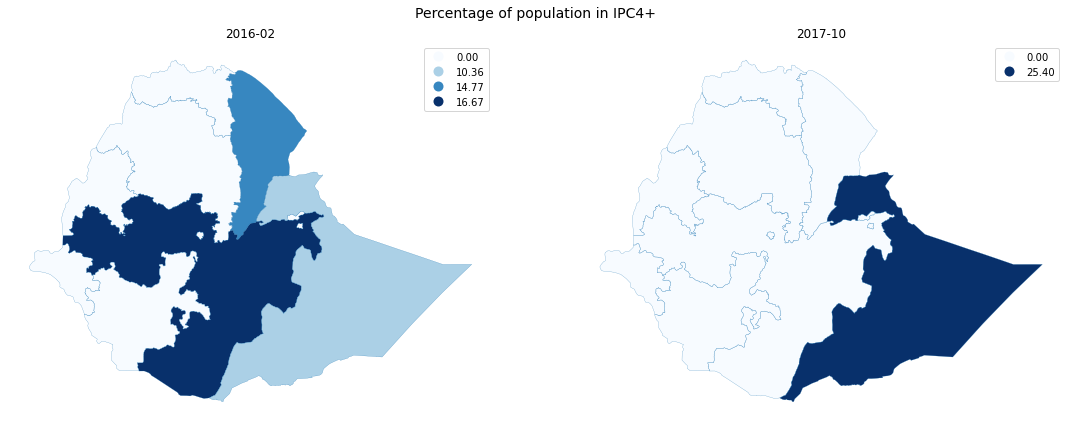

In [74]:
plot_aff_dates(df_ipc,dict_an["an2"]["df"],"perc_CS_4",title="Percentage of population in IPC4+")#dict_an["an3"]["trig_cols"])

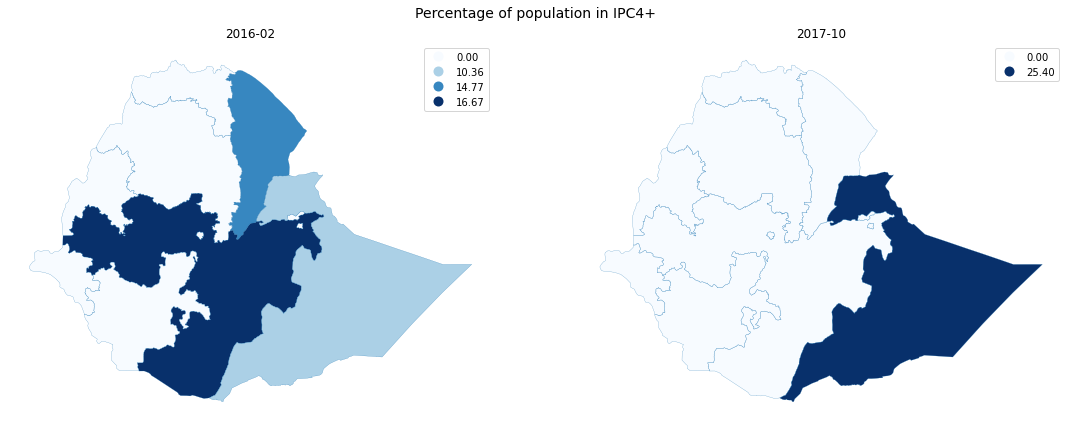

In [75]:
plot_aff_dates(df_ipc,dict_an["an2"]["df"],"perc_CS_4",title="Percentage of population in IPC4+")#dict_an["an3"]["trig_cols"])

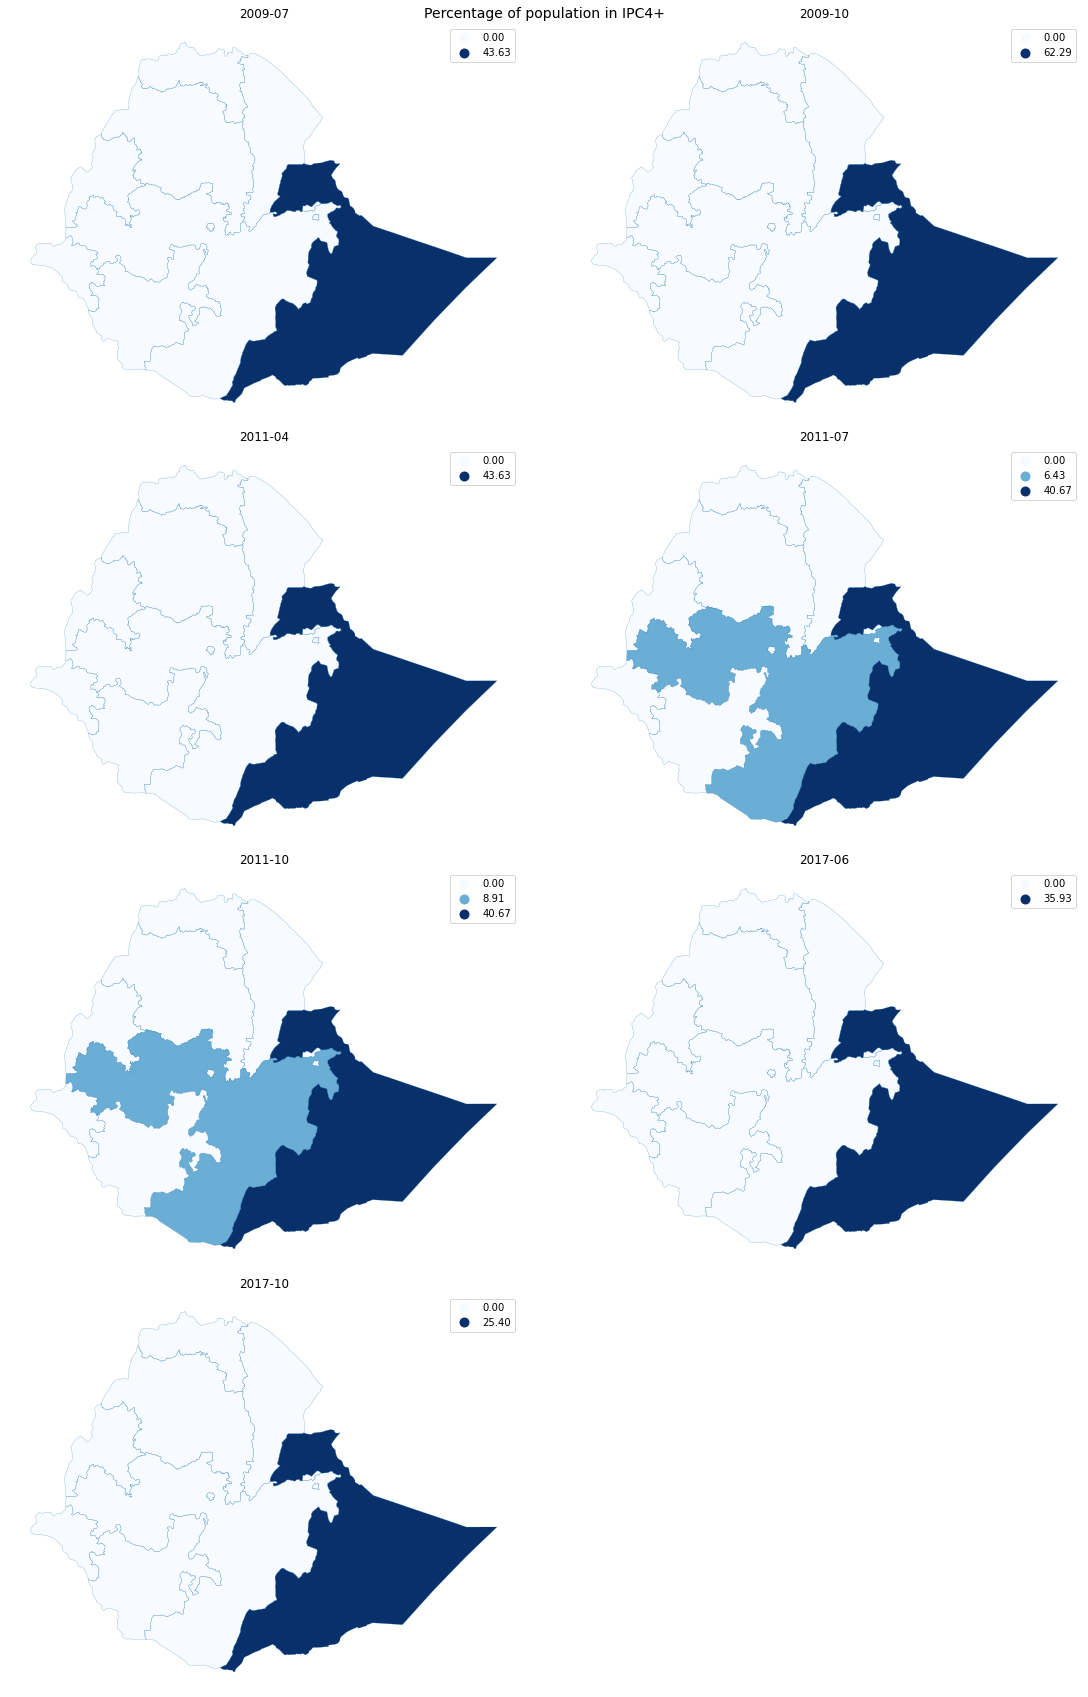

In [76]:
plot_aff_dates(df_ipc,dict_an["an3"]["df"],"perc_CS_4",title="Percentage of population in IPC4+")#dict_an["an3"]["trig_cols"])

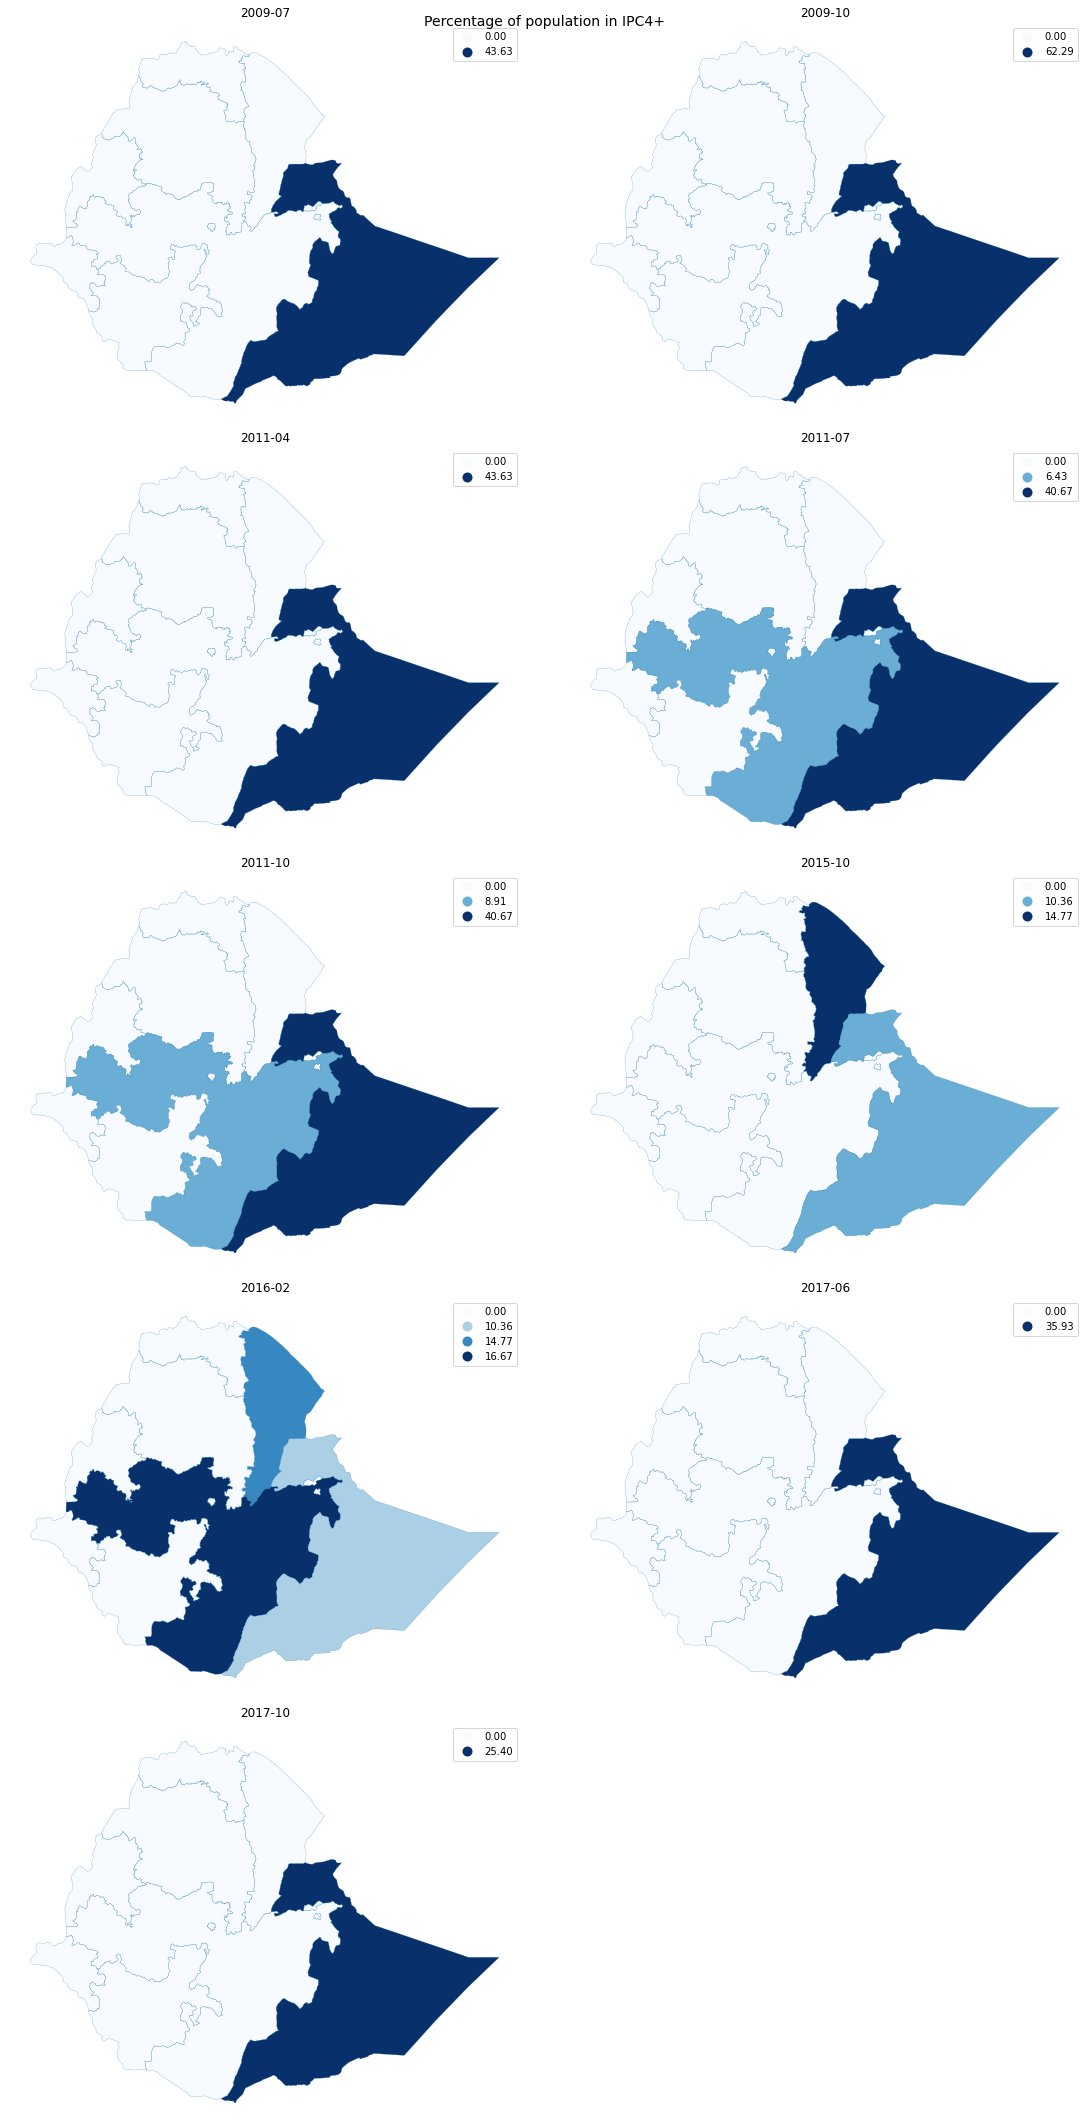

In [77]:
plot_aff_dates(df_ipc,dict_an["an5"]["df"],"perc_CS_4",title="Percentage of population in IPC4+")#dict_an["an3"]["trig_cols"])

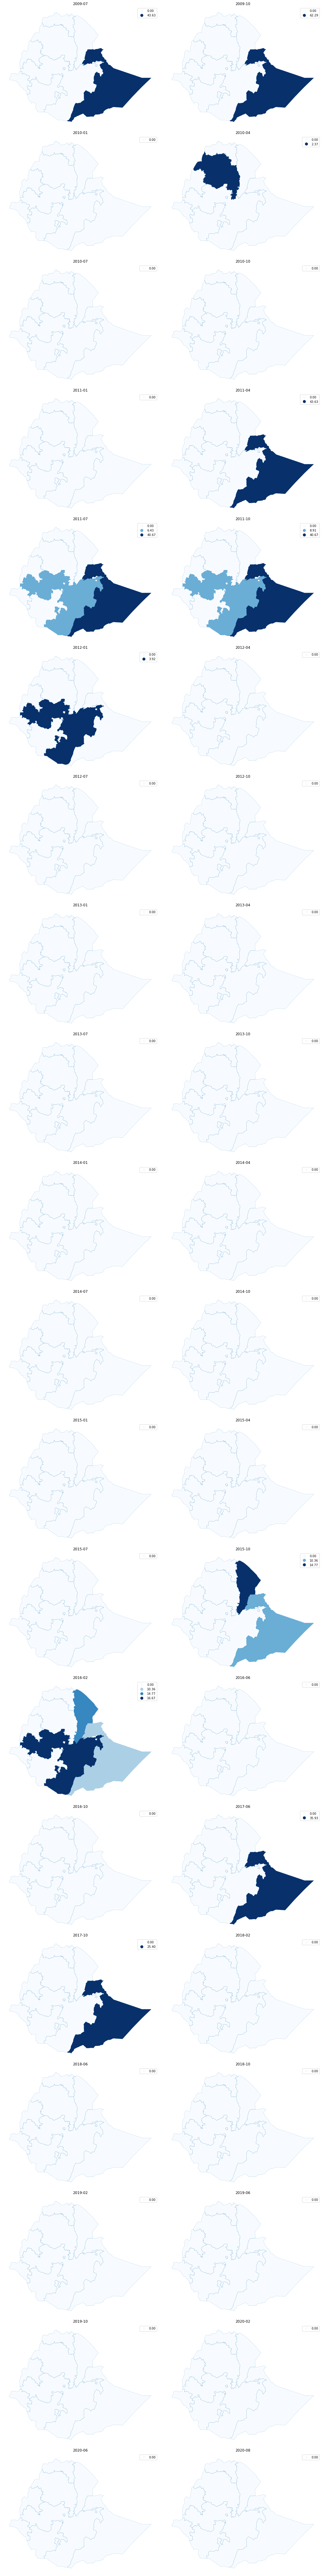

In [78]:
plot_aff_dates(df_ipc,df_ipc,"perc_CS_4")

In [79]:
# plot_aff_collist(df_ipc[df_ipc.date=="2009-07"],["perc_CS_3","perc_CS_4","ML1_4"])

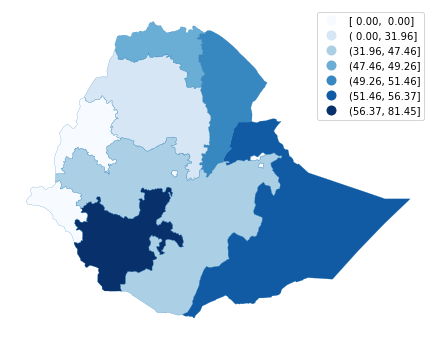

In [80]:
plot_aff_col(df_ipc[df_ipc.date=="2009-07"],"perc_CS_3")

In [81]:
df_ipc["perc_CS_4"].value_counts().sort_index()

0.000000     424
2.370133     1  
3.917397     1  
6.429118     1  
8.905064     1  
10.363111    1  
10.363115    1  
14.773917    1  
14.773934    1  
16.670120    1  
25.397151    1  
35.931007    1  
40.672886    2  
43.631946    1  
43.631955    1  
62.292521    1  
Name: perc_CS_4, dtype: int64

In [82]:
# sns.distplot(df_ipc["perc_CS4"])#,binwidth=1)#,x="perc_CS4")

In [83]:
def plot_regions_trig(df_trig,adm0c="ADM0_EN",adm1c="ADM1_EN",shape_path="Data/ET_Admin2_OCHA_2019/eth_admbnda_adm2_csa_bofed_20190827.shp"):
     #'ET_Admin2_2014/ET_Admin2_2014.shp'
    gdf = gpd.read_file(shape_path)

    count = 1
    f, ax = plt.subplots(figsize=(12,12))
    for d in ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']:
        ax2 = plt.subplot(4, 4, count)
        gdf.plot(ax=ax2, color='#DDDDDD', edgecolor='#BBBBBB')
        regions = df_trig[adm1c].loc[df_trig['year'].astype(str)==d]
        gdf.loc[gdf[adm1c].isin(regions)].plot(ax=ax2, color='red')
        plt.title("Regions triggered")
        count+=1
    plt.show()

In [84]:
# plot_regions_trig(dict_an["an5"]["df"])

### Old stuff

In [85]:
# df_ipc[df_ipc.date.isin(["2019-10-01","2020-06-01"])].sort_values(["date","ADM1_EN"]).drop("Total",axis=1)

In [86]:
# df_ipc.equals(df_ipc2)
# a=pd.concat([df_ipc,df_ipc2]).drop_duplicates(keep=False)

In [87]:
# #calculate increase in ml1 compared to ml2 in percentage
# df_ipc[f"ML1_i"]=((df_ipc[[f"ML1_{i}" for i in range(3,6)]].sum(axis=1)-df_ipc[[f"CS_{i}" for i in range(3,6)]].sum(axis=1))*100/df_ipc[[f"CS_{i}" for i in range(3,6)]].sum(axis=1)).replace(np.inf,0).replace(np.nan,0)
# df_ipc[f"ML1_i2"]=((df_ipc[[f"ML1_{i}" for i in range(3,6)]].sum(axis=1)-df_ipc[[f"CS_{i}" for i in range(3,6)]].sum(axis=1))*100/df_ipc["pop_CS"])#.replace(np.inf,0).replace(np.nan,0)